![](Rydiqule_Logo_Transparent_300.png)

# Analytic Doppler Solver

This notebook demonstrates how to use rydiqule's implementation ([`solve_doppler_analytic`](https://rydiqule.readthedocs.io/page/api/_autosummary/rydiqule.doppler_exact.solve_doppler_analytic.html#rydiqule-doppler-exact-solve-doppler-analytic)) of the analytical doppler solver described in
Omar Nagib and Thad G. Walker, *Exact steady state of perturbed open quantum systems*,
[Phys. Rev. Research 7, 033076 (2025)](https://doi.org/10.1103/kgsg-3npp).
It contains examples with 1D/2D/3D Doppler averaging along with detailed profiling performance to highlight improvements.

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/Analytical%20Doppler%20Demo.ipynb).


## 1D Doppler Averaging

We will look at a simple case of Autler-Townes splitting in Rubidium-87 with two optical fields (blue and red). Applying an RF tone at different field strengths causes the central peak to split and shift as we scan the probe detuning. We show excellent agreement between numerically integrating the effect of Doppler broadening and the new exact method.


In [1]:
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rydiqule as rq

In [3]:
# parameters for Cell
atom = 'Rb87'

states = [
    rq.ground_state(atom),
    rq.D2_excited(atom),
    rq.A_QState(41,2,5/2),
    rq.A_QState(40,3,7/2)
]


cell = rq.Cell(atom, states)

In [4]:
# laser parameters
detunings = 2*np.pi*np.linspace(-30,30,201)
Omega_r = 2*np.pi*2
Omega_b = 2*np.pi*5
Omega_rf = 2*np.pi*np.array([0,5,40])

kunit1 = np.array([1,0,0])
kunit2 = np.array([-1,0,0])

red = {'states': (states[0],states[1]), 'detuning': detunings, 'rabi_frequency': Omega_r, 'kunit': kunit1}
blue = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_b, 'kunit': kunit2}
rf = {'states': (states[2],states[3]), 'detuning': 0, 'rabi_frequency': Omega_rf}

cell.add_couplings(red, blue, rf)

### Method comparison

The analytic averaging method has significantly higher accuracy than the default discrete Riemann sums used by `solve_steady_state`;
the default meshing having been chosen to target sufficient accuracy (~1%) for optimal speed.
This function compares results from different solve methods to demonstrate the increase in accuracy.
We will also time each method for comparison.

In [5]:
def compare_accuracy(sol1: np.ndarray, sol2: np.ndarray,
                     rtol: float = 1e-5, atol: float = 1e-7):
    """Helper function for summarizing relative and absolute differences between
    density matrix solutions.
    
    Note that sol1 is considered the 'correct' solution in the comparison.
    
    Tolerances are passed to numpy.isclose for defining how close something is."""

    assert sol1.shape == sol2.shape, 'solutions must have same shape to be compared'
    abs_diff = np.abs(sol2 - sol1)
    null_elem = np.isclose(sol1, 0.0)
    sol_ref = sol1.copy()
    sol_ref[null_elem] = 1.0
    rel_diff = abs_diff/np.abs(sol_ref)
    rel_diff[null_elem] = 0.0
    print(f'Abs(diff) max {abs_diff.max():.3e}, mean {abs_diff.mean():.3g}, std {abs_diff.std():.3g}')
    print(f'Rel(diff) max {rel_diff.max():.3e}, mean {rel_diff.mean():.3g}, std {rel_diff.std():.3g}')

    close = np.isclose(sol2, sol1, rtol=rtol, atol=atol)  # element-wise close
    close_sys = close.all(axis=-1)  # density-matrix wise close
    if not close_sys.all():
        print(f'Not close matrix elements {(~close).sum():d} out of {close.size:d} total')
        print(f'Not close solutions {(~close_sys).sum():d} out of {close_sys.size:d} total')
        not_close_inds = (~close).nonzero()
        vals, counts = np.unique(not_close_inds[2], return_counts=True)
        for l, v, c in zip(cell.dm_basis(), vals, counts):
            print(f'\tdm element {l:s}-[{v:d}] has {c:d} misses: ' +
                  f'Abs-diff (max, mean, diff) {abs_diff[...,v].max():.3e}, {abs_diff[...,v].mean():.3e}, {abs_diff[...,v].std():.3e}')
        return not_close_inds

In [6]:
%%time
sol_riemann = rq.solve_steady_state(cell, doppler=True)

CPU times: total: 2.39 s
Wall time: 991 ms


In [7]:
dop_mesh_method = {'method': 'split',
                   'width_doppler': 2.0,
                   'n_doppler': 201,
                   'width_coherent': 0.28,
                   'n_coherent': 1001}

In [8]:
%%time
sol_riemann_finer = rq.solve_steady_state(cell, doppler=True, doppler_mesh_method=dop_mesh_method)

CPU times: total: 3.17 s
Wall time: 1.86 s


In [9]:
%%time
sol_exact = rq.solve_doppler_analytic(cell)

CPU times: total: 46.9 ms
Wall time: 64.1 ms


In [10]:
bad_inds = compare_accuracy(sol_exact.rho, sol_riemann.rho, rtol=1e-5, atol=7e-5)

Abs(diff) max 1.797e-04, mean 1.61e-05, std 2.88e-05
Rel(diff) max 1.137e+03, mean 0.784, std 22.4
Not close matrix elements 593 out of 9045 total
Not close solutions 399 out of 603 total
	dm element 01_real-[1] has 220 misses: Abs-diff (max, mean, diff) 1.797e-04, 5.971e-05, 4.712e-05
	dm element 02_real-[2] has 100 misses: Abs-diff (max, mean, diff) 1.615e-04, 3.366e-05, 3.979e-05
	dm element 03_real-[7] has 112 misses: Abs-diff (max, mean, diff) 1.604e-04, 4.080e-05, 3.453e-05
	dm element 01_imag-[9] has 73 misses: Abs-diff (max, mean, diff) 1.082e-04, 3.516e-05, 2.708e-05
	dm element 11_real-[11] has 49 misses: Abs-diff (max, mean, diff) 1.221e-04, 2.376e-05, 2.820e-05
	dm element 12_real-[14] has 39 misses: Abs-diff (max, mean, diff) 9.864e-05, 2.241e-05, 2.532e-05


In [11]:
bad_inds_finer = compare_accuracy(sol_exact.rho, sol_riemann_finer.rho, rtol=1e-5, atol=7e-5)

Abs(diff) max 5.529e-06, mean 2.95e-07, std 5.47e-07
Rel(diff) max 3.176e+01, mean 0.0173, std 0.483


In [12]:
%timeit rq.solve_doppler_analytic(cell)

55.6 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


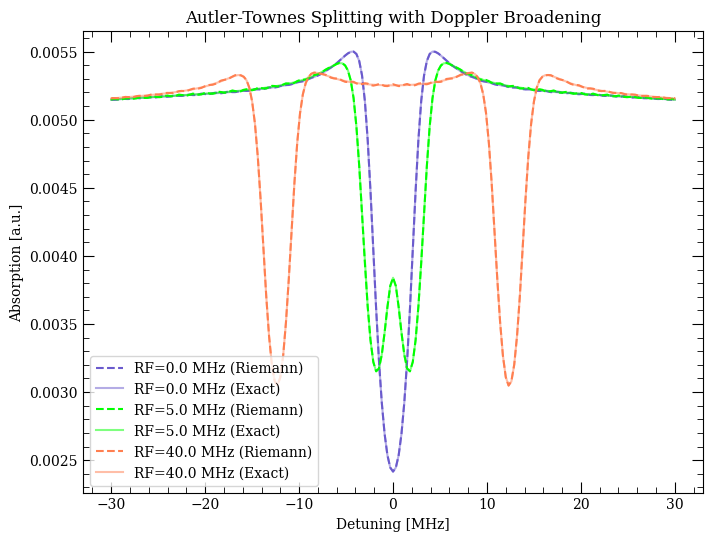

In [13]:
colors=['slateblue', 'lime', 'coral']
plt.figure(figsize=(8,6))
for i in range(len(Omega_rf)):
    plt.plot(detunings/(2*np.pi), sol_riemann.rho_ij(1,0)[:,i].imag,
             label=f'RF={Omega_rf[i]/(2*np.pi):.1f} MHz (Riemann)', c=colors[i], linestyle='dashed')
    plt.plot(detunings/(2*np.pi), sol_exact.rho_ij(1,0)[:,i].imag,
             label=f'RF={Omega_rf[i]/(2*np.pi):.1f} MHz (Exact)', c=colors[i], alpha=0.5)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Absorption [a.u.]')
plt.legend()
plt.title('Autler-Townes Splitting with Doppler Broadening')
plt.show()

## 2D Doppler Averaging

This example follows the experimental setup in Glick et al. (https://arxiv.org/pdf/2506.04504). It is a $Rb^{85}$ vapor with a $5S_{1/2} \rightarrow 5P_{1/2} \rightarrow 6S_{1/2} \rightarrow 31P_{1/2}$ excitation pathway and corresponding optical fields of 795 nm, 1324 nm, and 745 nm. These fields are called probe, dressing, and Rydberg, respectively.

We simulate the EIT spectra of the collinear and Doppler-free configurations using the solve_doppler_analytic function that solves the collinear configuration analytically and the Doppler-free configuration using a hybrid analytic/numeric method.

In [14]:
# parameters for Cell
atom = 'Rb85'

states = [
    rq.A_QState(5,0,1/2),
    rq.A_QState(5,1,1/2),
    rq.A_QState(6,0,1/2),
    rq.A_QState(31,1,1/2)
]

sensor = rq.Cell(atom, states)

In [15]:
# laser parameters
detunings = 2*np.pi*np.linspace(-10,10,201)
Omega_p = 2*np.pi*2
Omega_d = 2*np.pi*10
Omega_R = 2*np.pi*1

### 2D Collinear configuration

In [16]:
kunit1 = np.array([-1,0,0])
kunit2 = np.array([1,0,0])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunit1}
dressing = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d, 'kunit': kunit1}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunit2}

sensor.add_couplings(probe, dressing, Rydberg)
sols_col = rq.solve_doppler_analytic(sensor)

### 2D Doppler-free configuration

In this configuration, we show the ability of rydiqule to solve systems using a hybrid analytic/numeric approach, where one user-designated spatial dimension is averaged analytically and the other is averaged numerically. 

In [17]:
theta = 4.526
phi = 2.556

kunit1 = np.array([-1,0,0])
kunit2 = np.array([-1*np.cos(theta),-1*np.sin(theta),0])
kunit3 = np.array([-1*np.cos(phi),-1*np.sin(phi),0])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunit1}
dressing = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d, 'kunit': kunit2}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunit3}

sensor.add_couplings(probe, dressing, Rydberg)

In [18]:
sols_DF = rq.solve_doppler_analytic(sensor, analytic_axis=0)
sols_DF_1 = rq.solve_doppler_analytic(sensor, analytic_axis=1)

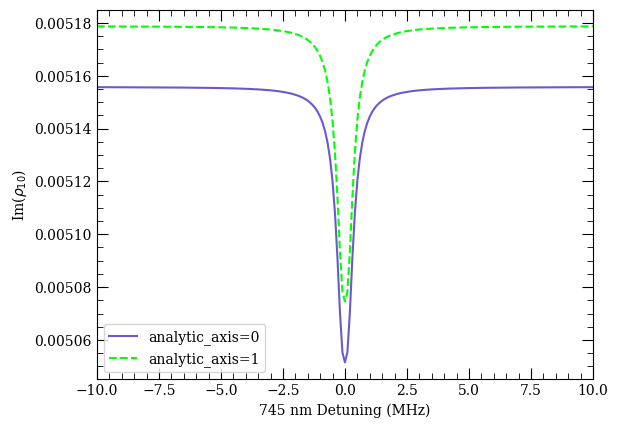

In [19]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), sols_DF.rho_ij(1,0).imag, c='slateblue', label="analytic_axis=0")
ax.plot(detunings/(2*np.pi), sols_DF_1.rho_ij(1,0).imag, c='lime', linestyle='dashed', label="analytic_axis=1")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Im($\rho_{10}$)")
ax.legend()

Note that, for some systems, the default mesh is not sufficient to properly capture the tails of the velocity distribution. That is, the distribution normalizes to something slightly less than one. Because the analytic method is much higher accuracy, this can cause a noticeable shift in the solutions depending on which axis is sampled. This can be remedied by increasing the `width_doppler` in the mesh method on the numeric axis.

In [20]:
m = {"method":"split", "width_doppler":2.7}
sols_DF_wider = rq.solve_doppler_analytic(sensor, analytic_axis=0, doppler_mesh_method=m)
sols_DF_1_wider = rq.solve_doppler_analytic(sensor, analytic_axis=1, doppler_mesh_method=m)

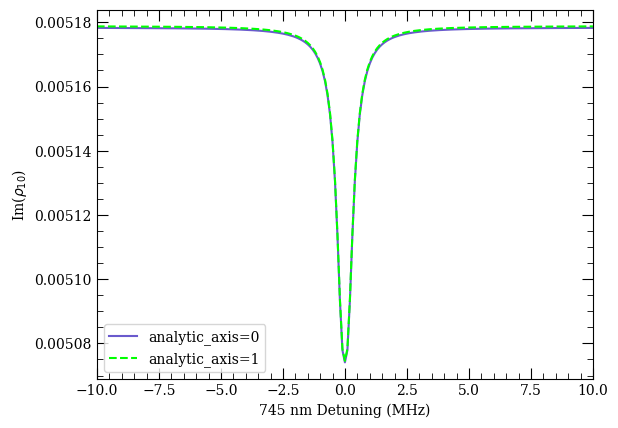

In [21]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), sols_DF_wider.rho_ij(1,0).imag, c='slateblue', label="analytic_axis=0")
ax.plot(detunings/(2*np.pi), sols_DF_1_wider.rho_ij(1,0).imag, c='lime', linestyle='dashed', label="analytic_axis=1")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Im($\rho_{10}$)")
ax.legend()

We can then recreate Figure 5b in the Glick et al. paper.

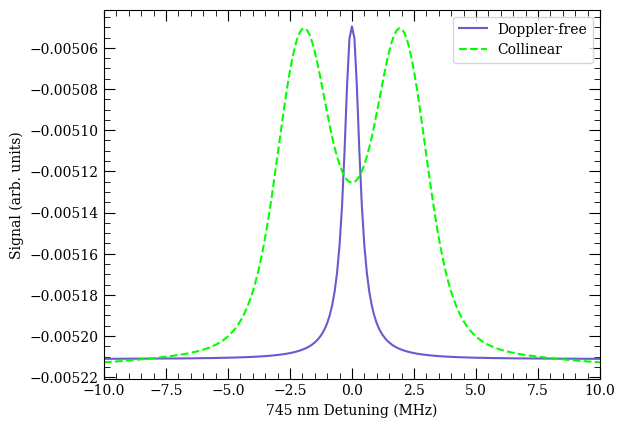

In [22]:
fig, ax = plt.subplots()
# note that paper figure has y-normalized data for both traces, here we just match DF scale/offset to Colinear data
ax.plot(detunings/(2*np.pi), (-1.55*(sols_DF.rho_ij(1,0).imag-5.155e-3)-5.21e-3), c='slateblue', label="Doppler-free")
ax.plot(detunings/(2*np.pi), -1*sols_col.rho_ij(1,0).imag, c='lime', linestyle='dashed', label="Collinear")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Signal (arb. units)")
ax.legend()

### 2D computation time and memory footprint improvements

We now show the decrease in both computation time and required memory footprint of the hybrid method in comparison to the existing numeric method.

In [23]:
%%time
sols_DF_riemann = rq.solve_steady_state(sensor, doppler=True, doppler_mesh_method=m)

CPU times: total: 2min 45s
Wall time: 2min 44s


In [24]:
%%time
sols_DF = rq.solve_doppler_analytic(sensor, analytic_axis=0, doppler_mesh_method = m)

CPU times: total: 6.12 s
Wall time: 4.72 s


In [25]:
from rydiqule.slicing.slicing import get_slice_num, get_slice_num_hybrid

get_slice_num(n=sensor.basis_size, stack_shape = (201,), doppler_shape=(601, 601), sum_doppler=True, weight_doppler=True, debug=True)

Total available memory: 228 GiB
Min Req memory to solve: 0.68633 GiB
Req memory per EOM: 0.68626 GiB
Req memory for full solve: 137.94 GiB
	Mandatory memory use: 7.0386e-05 GiB
	Memory use for all EOMs: 137.94 GiB
	Full output solution size: 2.2464e-05 GiB
Available memory for sliced solves: 228 GiB
Number of stack slices to be used: 1


(1, (201, 15))

In [26]:
get_slice_num_hybrid(n=sensor.basis_size, param_stack_shape=(201,), numeric_doppler_shape=(601,), debug=True)

--- Analytic Solver Memory Debug ---
Total available RAM: 228 GiB
Min Req memory to solve: 0.01075 GiB
Req memory for full solve: 2.16 GiB
	Full output solution size: 2.3961e-05 GiB
Available memory for sliced calculations: 228 GiB
Calculated minimum slices needed: 1.0
Final number of slices to be used: 1
------------------------------------


(1, (201, 16))

In [27]:
print(f'Wall time reduced by x{3*60/5:.0f}')
print(f'Solve memory requirement reduced by x{0.68633/0.01075:.0f}')

Wall time reduced by x36
Solve memory requirement reduced by x64


## 3D Doppler Averaging

This example follows the four photon excitation pathway in $Cs$ vapor given in Kondo et al. (https://arxiv.org/pdf/1510.01729). This pathway follows the ladder scheme $6S_{1/2} \rightarrow 6P_{3/2} \rightarrow 7S_{1/2} \rightarrow 8P_{1/2} \rightarrow 52D_{3/2}$ in cesium with corresponding optical fields 852 nm, 1470 nm, 1394 nm, and 1770 nm. These fields are labelled probe, dressing 1, dressing 2, and Rydberg, respectively.

We demonstrate using rydiqule to solve this system with the collinear configuration and with a doppler-free configuration. We include the disclaimer that we ignore the hyperfine structure present in the paper. The purpose of this example is to show that with `solve_doppler_analytic`, doppler averaging over 3 spatial dimensions is now a tractable computation compared to averaging with `solve_steady_state`.

In [28]:
# parameters for Cell
atom = 'Cs'

states = [
    rq.A_QState(6,0,1/2),
    rq.A_QState(6,1,3/2),
    rq.A_QState(7,0,1/2),
    rq.A_QState(8,1,1/2),
    rq.A_QState(52,2,3/2)
]

sensor = rq.Cell(atom, states)

In [29]:
# laser parameters
detunings = 2*np.pi*np.linspace(-10,10,51)
Omega_p = 2*np.pi*2
Omega_d1 = 2*np.pi*10
Omega_d2 = 2*np.pi*12
Omega_R = 2*np.pi*1

### 3D Collinear configuration

In [30]:
kunit1 = np.array([-1,0,0])
kunit2 = np.array([1,0,0])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunit1}
dressing1 = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d1, 'kunit': kunit2}
dressing2 = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d2, 'kunit': kunit2}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunit2}

sensor.add_couplings(probe, dressing1, dressing2, Rydberg)
sols_col = rq.solve_doppler_analytic(sensor)

Text(0, 0.5, 'Im($\\rho_{10}$)')

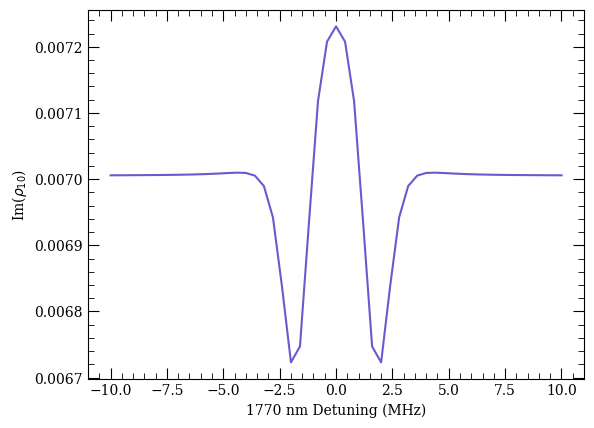

In [31]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), sols_col.rho_ij(1,0).imag, c='slateblue')
ax.set_xlabel("1770 nm Detuning (MHz)")
ax.set_ylabel(r"Im($\rho_{10}$)")

### 3D Doppler-free configuration

In [32]:
# 4 photon
detunings = 2*np.pi*np.linspace(-10,10,51)

theta_p, phi_p = np.pi/2, 0
theta_d1, phi_d1 = 0.3834, np.pi
theta_d2, phi_d2 = 2.1039, 2.6072
theta_R, phi_R = 2.0598, 3.8249

kunitp = np.array([np.sin(theta_p)*np.cos(phi_p), np.sin(theta_p)*np.sin(phi_p), np.cos(theta_p)])
kunitd1 = np.array([np.sin(theta_d1)*np.cos(phi_d1), np.sin(theta_d1)*np.sin(phi_d1), np.cos(theta_d1)])
kunitd2 = np.array([np.sin(theta_d2)*np.cos(phi_d2), np.sin(theta_d2)*np.sin(phi_d2), np.cos(theta_d2)])
kunitR = np.array([np.sin(theta_R)*np.cos(phi_R), np.sin(theta_R)*np.sin(phi_R), np.cos(theta_R)])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunitp}
dressing1 = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d1, 'kunit': kunitd1}
dressing2 = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d2, 'kunit': kunitd2}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunitR}

sensor.add_couplings(probe, dressing1, dressing2, Rydberg)

In [33]:
%%time
sols_DF = rq.solve_doppler_analytic(sensor, analytic_axis=0)

Breaking parameter stack into 4 slices...
CPU times: total: 24min 40s
Wall time: 24min 36s


Text(0, 0.5, 'Im($\\rho_{10}$)')

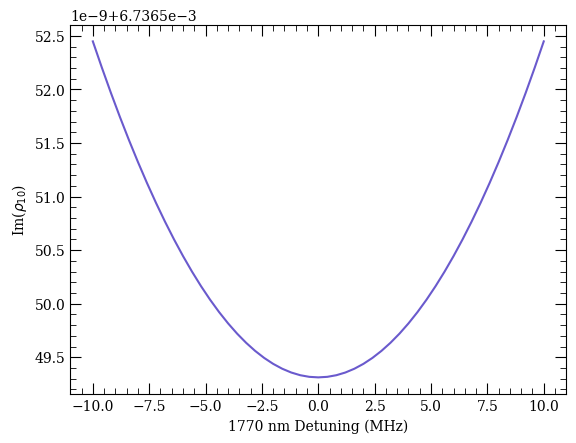

In [34]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), sols_DF.rho_ij(1,0).imag, c='slateblue')
ax.set_xlabel("1770 nm Detuning (MHz)")
ax.set_ylabel(r"Im($\rho_{10}$)")

### 3D memory footprint comparison

Here we only directly compare the memory footprint of the two methods, since the discrete sampling method results in too large a system to solve on even a moderately-sized workstation.

In [35]:
from rydiqule.slicing.slicing import get_slice_num, get_slice_num_hybrid

get_slice_num(n=sensor.basis_size, stack_shape = (51,), doppler_shape=(561, 561, 561), sum_doppler=True, weight_doppler=True, debug=True)

Total available memory: 231.27 GiB
Min Req memory to solve: 820.85 GiB
Req memory per EOM: 820.85 GiB
Req memory for full solve: 41863 GiB
	Mandatory memory use: 2.8118e-05 GiB
	Memory use for all EOMs: 41863 GiB
	Full output solution size: 9.1195e-06 GiB
Available memory for sliced solves: 231.27 GiB


RydiquleError: System is too large to solve. Need at least 820.8490894585848 GiB

In [36]:
get_slice_num_hybrid(n=sensor.basis_size, param_stack_shape=(51,), numeric_doppler_shape=(561,561), debug=True)

--- Analytic Solver Memory Debug ---
Total available RAM: 231.2 GiB
Min Req memory to solve: 13.54 GiB
Req memory for full solve: 690.6 GiB
	Full output solution size: 9.4995e-06 GiB
Available memory for sliced calculations: 231.2 GiB
Calculated minimum slices needed: 3.0
Final number of slices to be used: 3
------------------------------------


(3, (51, 25))

In [37]:
print(f'Solve memory requirement reduced by x{820.85/13.54:.0f}')

Solve memory requirement reduced by x61


In [38]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.1.1.dev18
Installation Path:    ~\src\rydiqule_public\src\rydiqule

      Dependencies
    
NumPy Version:        2.2.5
SciPy Version:        1.16.0
Matplotlib Version:   3.10.0
ARC Version:          3.6.0
Python Version:       3.11.10
Python Install Path:  ~\miniconda3\envs\rq_public
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB
